In [66]:
import numpy as np
from qiskit import *
from qiskit.circuit import Qubit
from qiskit.quantum_info import Statevector

Based on the adaptation of Möttönen et al's paper "Transformation of quantum states using uniformly controlled rotations".

This algorithm adaptation is written in "Supervised Learning with Quantum Computers" book by 

In [101]:
# a function to calculate the angle β

def beta(s, j, X_sample):
    # numerator index
    index_num = (2*j-1)*(2**(s-1))
    # denominator index
    index_den = (j-1)*(2**s)
    
    num = np.sqrt(np.sum(abs(X_sample[index_num : index_num+2**(s-1)])**2))
    den = np.sqrt(np.sum(abs(X_sample[index_den : index_den+2**(s)])**2))
    
    if den == 0:
        #print("Zero denominator!")
        beta = 0
    else:
        beta = 2*np.arcsin(num/den)
    
    return beta

In [239]:
def decimalToBinary(n, length):
    binary = bin(n).replace("0b", "")
    if len(binary) != length:
        for i in range(length - len(binary)):
            binary = "0" + binary
    
    return binary

def locate_x(current_j, prev_j, length):
    loc = []
    
    prev_binary = decimalToBinary(prev_j, length)
    counter = 0
    
    for i in decimalToBinary(current_j, length):
        if i != prev_binary[counter]:
            loc.append(counter)
        counter += 1
    
    return loc

In [285]:
def state_prep(X_sample):

    n = int(np.log2(len(X_sample)))

    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qr, cr)

    # for every qubits
    for i in range(n):
        # for every gates on the qubit
        if i == 0:
            qc.ry(beta(n, 1, X_sample), 0)
            qc.barrier()
        else:
            for j in range(2**i):
                if j != 0:
                    for loc in locate_x((2**i)-j-1, (2**i)-j, length=i):
                        qc.x(loc)

                control = [Qubit(qr, c) for c in range(i)]
                target = Qubit(qr, i)

                qc.mcry(beta(n-i, (2**i)-j, X_sample), control, target, None)

            for k in range(i):
                qc.x(k)

            qc.barrier()

    #qc.measure([b for b in range(n)], [b for b in range(n)])

    return qc

In [291]:
X_sample = np.array([np.sqrt(0.4), 0, np.sqrt(0.5), np.sqrt(0.1)])

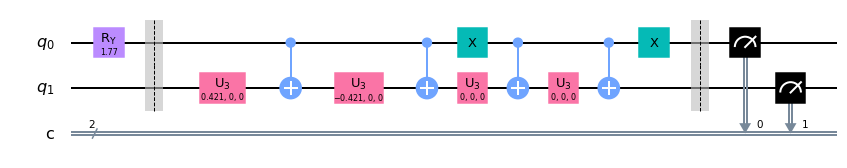

In [292]:
a = state_prep(X_sample)
n = int(np.log2(len(X_sample)))
a.measure([b for b in range(n)], [b for b in range(n)])
a.draw('mpl')

In [293]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')

from qiskit.visualization import plot_histogram

[0.4 0.  0.5 0.1]


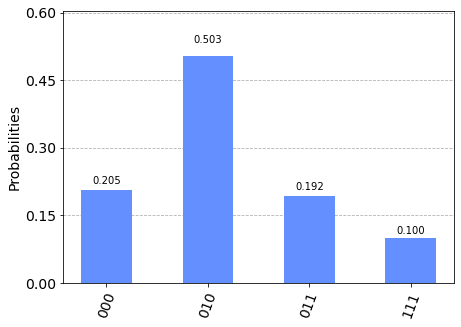

In [294]:
counts = execute(qc, backend=simulator, shots=10000).result().get_counts(qc)
print(X_sample**2)
plot_histogram(counts)